In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Dataset 확인

In [87]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-8/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-8/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/data/3-8/sample_submission.csv')

In [4]:
df_train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


* 예측하려는 target label은 price입니다.

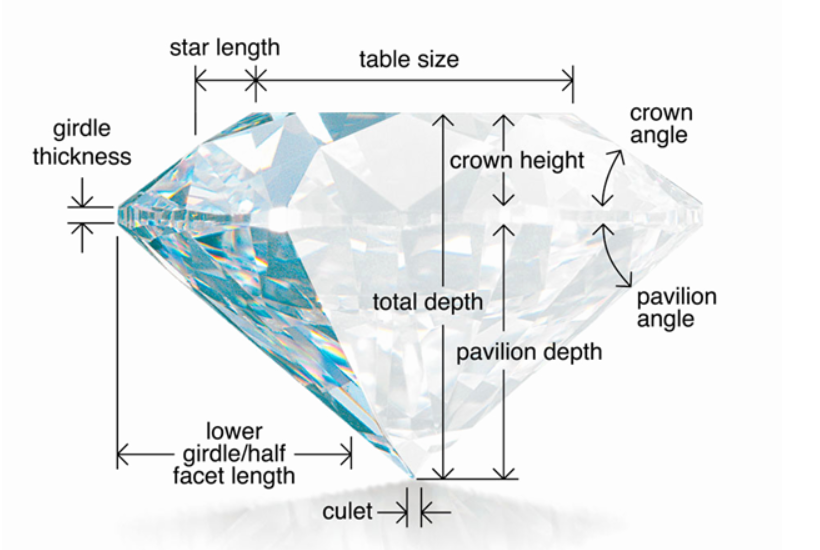

* 변수 설명 
    * carat : 무게
    * cut : 절단 품질 -> Fair < Good < Very Good < Premium < Ideal
    * color : 색 -> D가 가장 좋고 J가 가장 나쁘다
    * clarity : 선명도 - 내포물과 흠집이 없는 것을 의미(FL = 무결함 > IF > VVS1 > VVS2 > VS1 > VS2> SI1 > SI2 > I1 > I2 > I3 = 레벨 3 내포물)
    * depth : 높이를 평균 직경으로 나눈 값?
    * table : 평균 직경의 백분율로 표시된다.
    * x : 길이(mm)
    * y : 너비(mm)
    * z : 높이(mm)
    * price : 가격


In [ ]:
df_train.shape

(193573, 11)

In [ ]:
df_test.shape

(129050, 10)

In [ ]:
df_train.describe()

,id,carat,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,96786.000000,0.790688,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,55879.856166,0.462688,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.000000,0.200000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,48393.000000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,96786.000000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145179.000000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,193572.000000,3.500000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


In [ ]:
df_test.describe()

,id,carat,depth,table,x,y,z
count,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000
mean,258097.500000,0.789256,61.820522,57.239608,5.711767,5.716336,3.531802
std,37253.670457,0.462502,1.080249,1.918908,1.109666,1.102485,0.690749
min,193573.000000,0.200000,53.200000,51.000000,0.000000,0.000000,0.000000
25%,225835.250000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000
50%,258097.500000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000
75%,290359.750000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000
max,322622.000000,4.500000,70.600000,70.000000,10.140000,10.140000,31.800000


In [ ]:
df_train.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

* null값은 없다!!

## 1.1 Null data check

* null 값이 없으므로 pass

## 1.2 Target label 확인

In [ ]:
print('제일 비싼 가격: {:.1f}'.format(df_train['price'].max()))
print('제일 싼 가격 : {:.1f}'.format(df_train['price'].min()))
print('평균 가격: {:.1f}'.format(df_train['price'].mean()))

제일 비싼 가격: 18818.0
제일 싼 가격 : 326.0
평균 가격: 3969.2


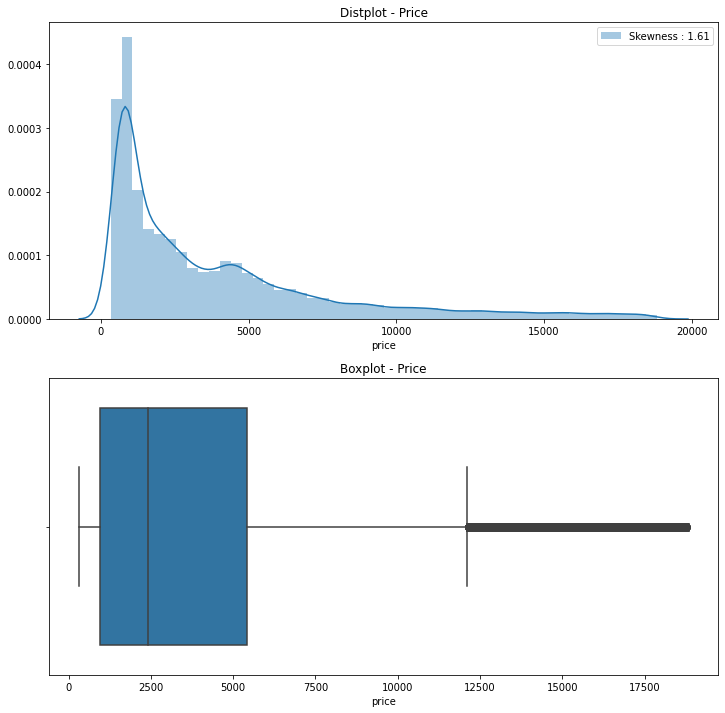

In [ ]:
f, ax = plt.subplots(2, 1, figsize = (12, 12))

g = sns.distplot(df_train['price'], label = 'Skewness : {:.2f}'.format(df_train['price'].skew()), ax = ax[0])
g = g.legend(loc='best')
ax[0].set_title('Distplot - Price')
ax[0].set_ylabel('')

sns.boxplot(df_train['price'], ax = ax[1])
ax[1].set_title('Boxplot - Price')

plt.show()

* pirce는 대부분 1000 ~ 5000 사이에 분포해 있다.
* 왜도는 1.61이다.
* 그래프가 왼쪽으로 치우쳐져 있는 것으로 보아 평균보다 가격이 싼 보석이 많다.

# 2. Baseline model

In [12]:
X_train = df_train.drop(['id', 'cut', 'color', 'clarity', 'price'], axis = 1)
y_train = df_train['price']

X_test = df_test.drop(['id', 'cut', 'color', 'clarity'], axis = 1)

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

model = xgb.XGBRegressor()
model.fit(X_tr, y_tr)
score = mean_squared_error(y_vld, model.predict(X_vld))
score

1289640.0936746201

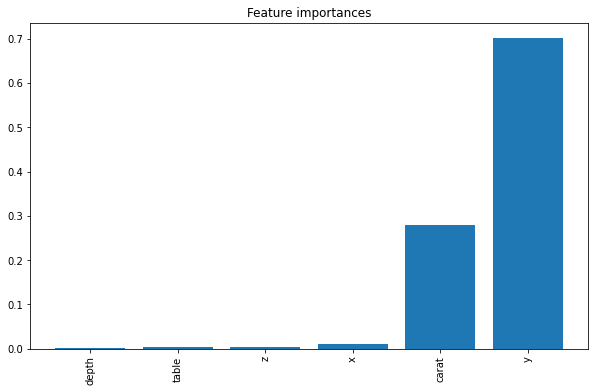

In [13]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = model.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

In [14]:
predictions = model.predict(X_test)
predictions

array([ 774.3243, 2995.4897, 2638.1467, ..., 5667.668 , 8462.108 ,
       5258.619 ], dtype=float32)

In [16]:
sub['price'] = predictions
sub.to_csv('/content/drive/MyDrive/data/3-8/sample_submission.csv', index = False)

# 3. Exploratory data analysis

* 연속형 : carcat, depth, table, x, y, z, price
* 이산형 : cut, color, clarity

In [19]:
continuous = ['carcat', 'depth', 'table', 'x', 'y', 'z', 'price']
discrete = ['cut', 'color', 'clarity']

* 무게는 무거울수록 가격이 비쌀 것 같다.
* 절단품질은 좋을수록 가격이 비쌀 것 같다.
* 색은 크게 영향을 줄 것 같지 않지만 좋은 색일수록 가격이 비쌀 것 같다.
* 선명도는 좋을수록 가격이 비쌀 것 같다.
* 높이와 테이블은 크게 영향을 줄 수 있는 label이 아닌 것 같다.
* x,y.z 각각 보다는 3개의 값이 골골루 높으면 가격이 비쌀 것 같다.

## 3.1 pandas-profiling을 통한 EDA

In [27]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 22.1 MB 23.3 MB/s 0:00:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 KB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 22.5 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=344582 sha256=7ba493a136b40a435ae7308f0521d2ac006845d476f77414632cae2c9727848c
  Stored in directory: /tmp/pip-ephem-wheel-cache-gpb4wy2l/wheels/64/b6/85/dfc808b23666a5910371784e349d28818006ff63ed9cfeca59
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 s

In [5]:
from pandas_profiling import ProfileReport

In [6]:
profile = ProfileReport(df_train)
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

* price와 높은 상관관계를 가지고 있는 변수는 carat(무게), x, y, z이다.

## 3.2 EDA

* 4C : carat, cut, color, clarity -> 4가지가 잘 어우러져야 좋은 보석이다.

* 다이아몬드는 가격 형성의 요인이 여러가지 있지만 최종은 carat(중량)으로 산정한다.
* 1캐럿은 0.2g이다.
* 캐럿이 크면 클수록 가치는 높아져 간다. -> 큰 것일수록 발굴 확률이 낮기 때문이다. 

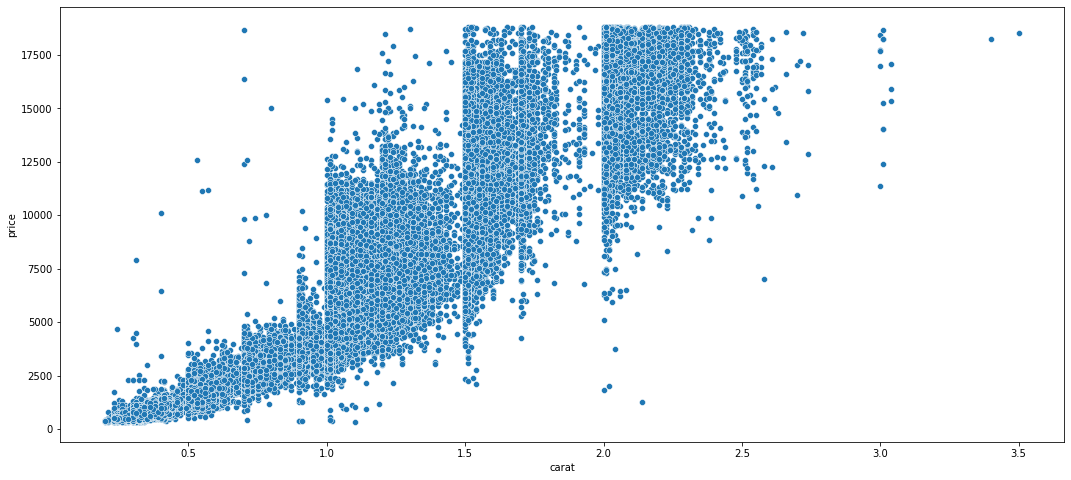

In [9]:
plt.figure(figsize = (18, 8))
sns.scatterplot(data = df_train, x = 'carat', y = 'price')
plt.show()

* 실제로 carat이 클수록 price가 대체로 비싸지는 것을 알 수 있다.
* carat이 작은데도 불구하고 price가 비싼 것과 carat이 큰데도 불구하고 price가 싼 것이 존재하는 이유는??

* 커팅 등급이 낮으면 가격만 비쌀뿐 광채가 약하다. -> 커팅 등급이 낮은데 가격이 비싼 이유는 커팅 등급이 높으면 그만큼 보석의 중량이 줄기 때문이다.

<AxesSubplot:xlabel='cut', ylabel='price'>

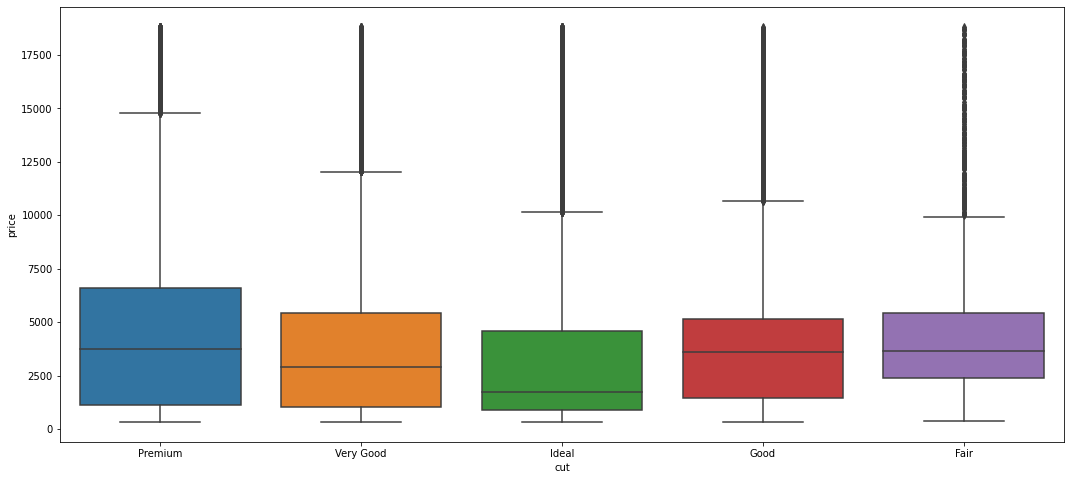

In [14]:
plt.figure(figsize = (18, 8))
sns.boxplot(data = df_train, x = 'cut', y = 'price')

<Figure size 1296x1080 with 0 Axes>

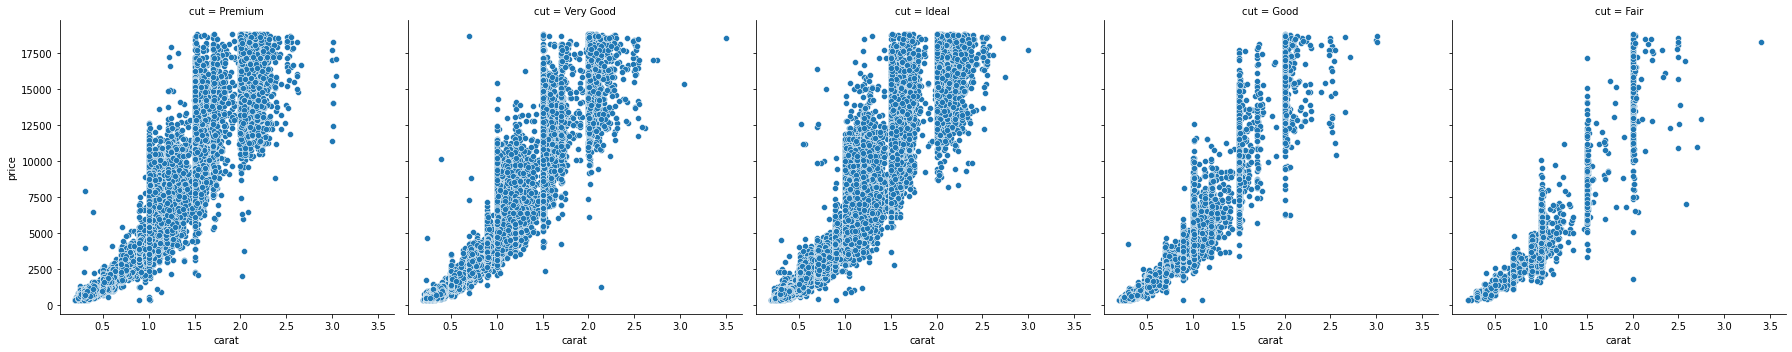

In [20]:
plt.figure(figsize = (18,15))
sns.relplot(data = df_train, x = 'carat', y = 'price', col = 'cut')
plt.show()

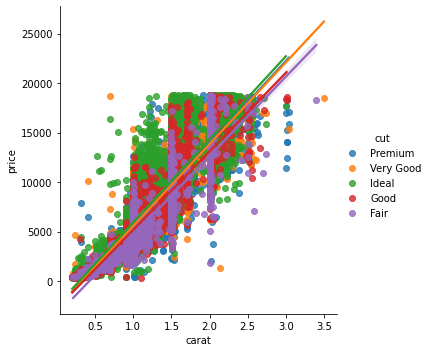

In [21]:
sns.lmplot(data = df_train, x = 'carat', y = 'price', hue = 'cut')

* 커팅 등급이 높은 ideal의 경우 대체로 price가 낮다. 
* 커팅 등급이 낮은 Fair의 경우 다른 등급에 비해 낮은 가격의 분포가 많지 않다.
* 커팅 등급에 따라 가격의 차이는 유의미하지 않을 것 같다. -> 우선 category별로 수치화만 시켜보는게 좋을 것 같다.

* D, E, F는 무색이고 G, H, I ,J는 거의 무색이다.
* 보석은 무색일수록 희귀하다.
* 색은 개인 취향이긴 하지만 무색이 희귀하기때문에 비쌀 것 같다. -> D,E,F가 G,H,I,J에 비해 비쌀 것 같다.

<AxesSubplot:xlabel='color', ylabel='price'>

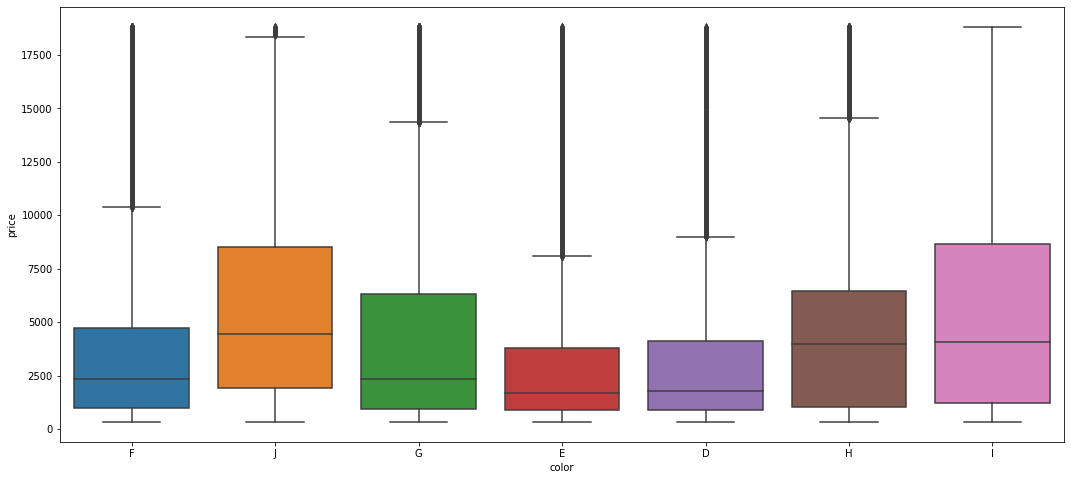

In [29]:
plt.figure(figsize = (18, 8))
sns.boxplot(data = df_train, x = 'color', y = 'price')

* 무색인 경우가 거의 무색인 경우보다 비싼 것 같지 않다. 오히려 더 싼 것 같다. 
* 분포로 봤을때 그래도 무색과 거의 무색으로 나뉘어지는 것 같다. -> 수치화를 두가지 부류로 시도해도 될 것 같다.
* 색은 취향차이인걸로...

* FL : 무결점
* IF : 내부는 아무런 결점이 없고 외부에 미세한 결점이 있는 상태
* VVS1, VVS2 : 매우 작은 내포물을 포함하고 있는 상태
* VS1, VS2 : 비교적 작은 내포물을 포함하고 있는 상태
* SI-1, SI2 : 작은 내포물을 포함하고 있는 상태
* I1, I2, I3 : 보조도구 없어도 내포물을 직접 확인할 수 있는 상태

* 무결점인 보석은 거의 없습니다. -> 희귀하므로 가장 비쌀 것이다.
* 내포물 함유량이 적고 내포물 크기가 작을수록 희귀한 다이아몬드이다.
* 투명도가 좋을수록 가격이 비쌀 것이다.

<AxesSubplot:xlabel='price', ylabel='Density'>

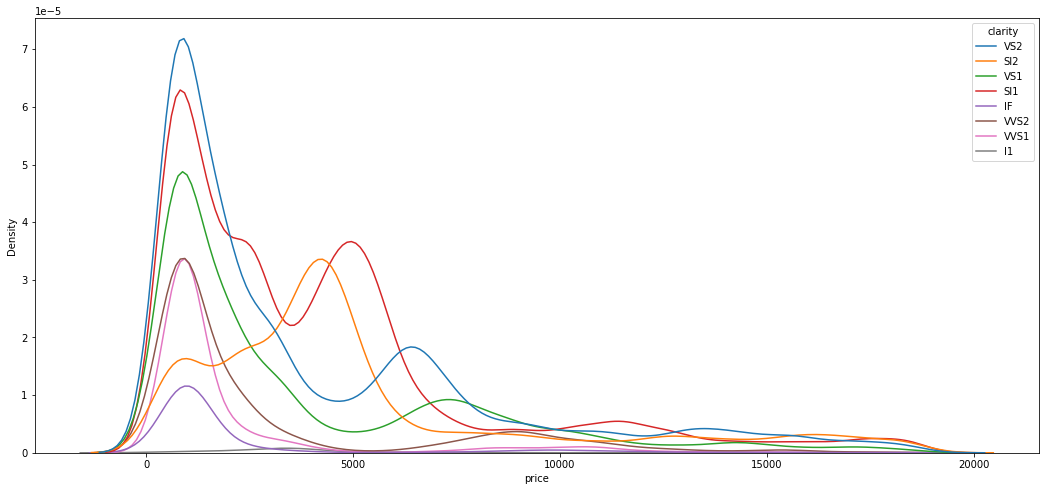

In [40]:
plt.figure(figsize = (18, 8))
sns.kdeplot(data = df_train, x = 'price', hue = 'clarity')

* 등급이 IF ~ I1까지 있다.

<AxesSubplot:xlabel='price', ylabel='Density'>

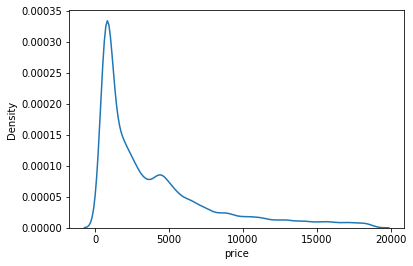

In [44]:
# 희귀한 보석
df_IF = df_train[df_train['clarity'] == 'IF']

sns.kdeplot(data = df_train, x = 'price')

* 무결점하다고 다른 보석에 비해 비싼 보석이 많은 것 같지는 않다.
* 오히려 특출나게 무결점하거나 특출나게 무결점하지 않은 보석보다는 중간 정도의 무결점을 가진 보석이 다른 보석들과는 다른 분포를 가지고 있다. -> 특히 무결점이 SI인 보석은 price가 다른 보석과는 다른 분포를 가지고 있다.

<AxesSubplot:xlabel='clarity', ylabel='count'>

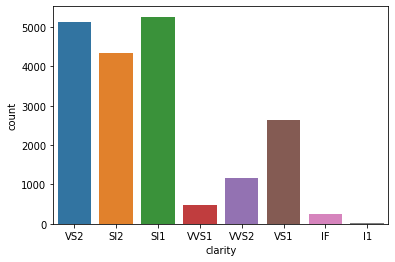

In [47]:
# price가 10000 이상인 데이터
df_exp = df_train[df_train['price'] >= 10000]

sns.countplot(data = df_exp, x = 'clarity')

* 비싼 보석중에서도 IF보다는 중간정도의 SI1, VS2가 많다.
* VS2, SI2, SI1를 하나로 묶어 분류하는 것이 좋아보인다.

!! category변수를 numeric 변수로 변환할 때 임의로 묶어주면 안된다. 

* depth : total_length / 평균 직경
* table : 평균 직경의 백분율

In [80]:
df_train['table']

0         58.0
1         58.0
2         57.0
3         56.0
4         59.0
          ... 
193568    56.0
193569    58.0
193570    57.0
193571    55.0
193572    64.0
Name: table, Length: 193573, dtype: float64

In [81]:
df_train['depth']

0         62.2
1         62.0
2         61.2
3         61.6
4         62.6
          ... 
193568    61.1
193569    60.3
193570    63.1
193571    62.9
193572    60.8
Name: depth, Length: 193573, dtype: float64

# 4. Feature engineering

In [88]:
def cut_function(x):
    if x == 'Fair':
        return 0
    elif x == 'Good':
        return 1
    elif x == 'Very Good':
        return 2
    elif x == 'Premium':
        return 3
    else:
        return 4

def color_function(x):
    if (x == 'D') or (x =='E') or (x == 'F'):
        return 0
    else:
        return 1

# def clarity_function(x):
#     if (x == 'VS2') or (x =='SI2') or (x == 'SI1'):
#         return 0
#     else:
#         return 1

def clarity_function(x):
    if x == 'I1':
        return 0
    elif 'SI' in x:
        return 1
    elif 'VVS' in x:
        return 3
    elif 'VS' in x:
        return 2
    else:
        return 4

In [89]:
df_train['cut_num'] = df_train['cut'].apply(cut_function)
df_test['cut_num'] = df_test['cut'].apply(cut_function)

df_train['color_num'] = df_train['color'].apply(color_function)
df_test['color_num'] = df_train['color'].apply(color_function)

df_train['clar_num'] = df_train['clarity'].apply(clarity_function)
df_test['clar_num'] = df_test['clarity'].apply(clarity_function)

In [90]:
cut_map = {'Fair':0,
           'Good':1,
           'Very Good':2,
           'Premium':3,
           'Ideal':4}
df_train['cut'] = df_train['cut'].map(cut_map)
df_test['cut'] = df_test['cut'].map(cut_map)

color_map = {'D':0, 
             'E':1, 
             'F':2, 
             'G':3, 
             'H':4, 
             'I':5, 
             'J':6}
df_train['color'] = df_train['color'].map(color_map)
df_test['color'] = df_test['color'].map(color_map)

clarity_map = {'IF':0, 
               'VVS1':1, 
               'VVS2':2, 
               'VS1':3, 
               'VS2':4, 
               'SI1':5, 
               'SI2':6, 
               'I1':7, 
               'I2':8, 
               'I3':9}
df_train['clarity'] = df_train['clarity'].map(clarity_map)
df_test['clarity'] = df_test['clarity'].map(clarity_map)

In [91]:
df_train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price,cut_num,color_num,clar_num
0,0,1.52,3,2,4,62.2,58.0,7.27,7.33,4.55,13619,3,0,2
1,1,2.03,2,6,6,62.0,58.0,8.06,8.12,5.05,13387,2,1,1
2,2,0.70,4,3,3,61.2,57.0,5.69,5.73,3.50,2772,4,1,2
3,3,0.32,4,3,3,61.6,56.0,4.38,4.41,2.71,666,4,1,2
4,4,1.70,3,3,4,62.6,59.0,7.65,7.61,4.77,14453,3,1,2


<AxesSubplot:>

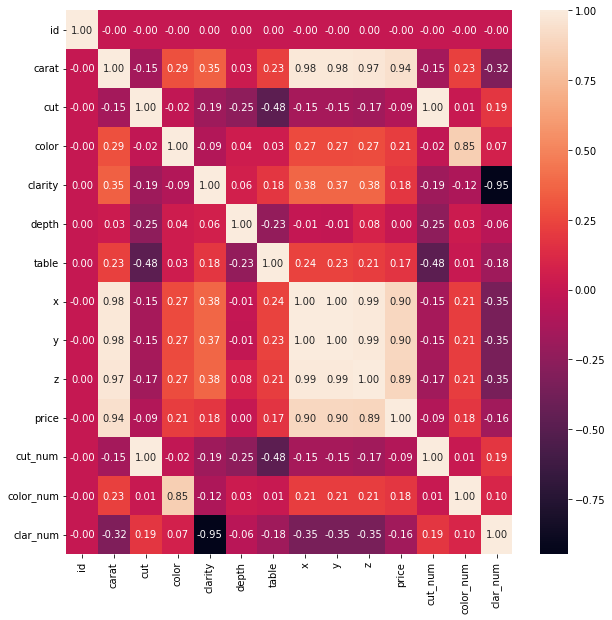

In [92]:
# correlation
plt.figure(figsize = (10, 10))
sns.heatmap(df_train.corr(), annot = True, fmt = '.2f')

In [93]:
df_train.loc[df_train['x']==0, 'x'] = df_train.x.mean()
df_test.loc[df_test['x']==0, 'x'] = df_test.x.mean()

df_train.loc[df_train['y']==0, 'y'] = df_train.y.mean()
df_test.loc[df_test['y']==0, 'y'] = df_test.y.mean()

df_train.loc[df_train['z']==0, 'z'] = df_train.z.mean()
df_test.loc[df_test['z']==0, 'z'] = df_test.z.mean()

df_train.loc[df_train['z']>10, 'z'] = df_train.z.mean()
df_test.loc[df_test['z']>10, 'z'] = df_test.z.mean()

In [94]:
df_train['volumn'] = df_train['x']*df_train['y']*df_train['z']
df_test['volumn'] = df_test['x']*df_test['y']*df_test['z']

# 5. Modeling

In [95]:
X_train = df_train.drop(['id', 'price'], axis = 1)
# X_train = df_train[['carat', 'cut_num', 'color_num', 'clar_num']]
y_train = df_train['price']

X_test = df_test.drop(['id'], axis = 1)
# X_test = df_test[['carat', 'cut_num', 'color_num', 'clar_num']]

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

model = xgb.XGBRegressor(random_state = 42)
# model2 = RandomForestRegressor(random_state = 42)
model.fit(X_tr, y_tr)
score = mean_squared_error(y_vld, model.predict(X_vld))
score

348923.25579347485

* carat 사용 : 1338111.1376744886
* carat, cut_num 사용 : 1299966.8786669355
* carat, cut_num, color_num 사용 : 1207039.460989934 -> baseline model보다 좋아졌다.
* carat, cut_num, color_num, clar_num 사용 : 944095.3649795783
* 카테고리 변수를 수치화한 변수와 id를 제외한 모든 numeric 변수 사용 : 931290.4333417179
--------------------------------------------------------------------------------
* 3/7
* clar_num 조정 후 : 673929.9656986273
* category 변수를 항목별로 다시 수치화해주고 x,y,z 이상치를 평균으로 대체하고 x,y,z를 모두 곱한 volumn 변수 추가 : 348923.25579347485

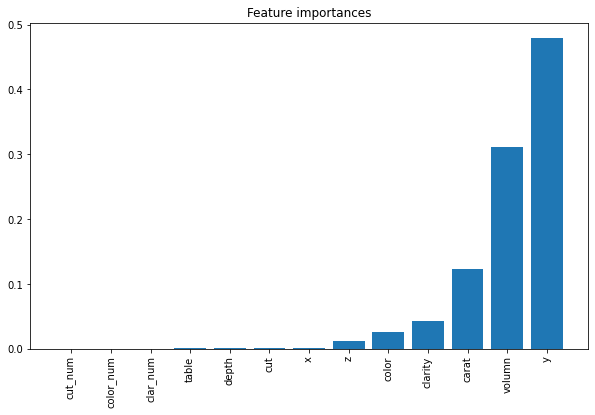

In [96]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = model.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

In [79]:
predictions = model.predict(X_test)
predictions

array([ 880.086 , 2514.868 , 2296.3035, ..., 7542.659 , 5709.8267,
       4256.434 ], dtype=float32)

In [68]:
sub['price'] = predictions
sub.to_csv('/content/drive/MyDrive/data/3-8/sample_submission.csv', index = False)